In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.stats import multivariate_normal, norm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys

import warnings

## Sample portfolios for illustrative risk calculation

In [ ]:
years = 50

n_portfolios = 4
portfolio_assets = np.zeros((n_portfolios, years))
portfolio_liabilities = np.zeros((n_portfolios, years))

def load_portfolios_from_csv(file_path, years=50, n_portfolios=4):
    df = pd.read_csv(file_path)
    
    portfolio_assets = np.zeros((n_portfolios, years))
    portfolio_liabilities = np.zeros((n_portfolios, years))
    
    for i in range(n_portfolios):
        asset_col = f"A{i+1}"
        liability_col = f"L{i+1}"
        portfolio_assets[i] = df[asset_col].values[:years]
        portfolio_liabilities[i] = df[liability_col].values[:years]
    
    return portfolio_assets, portfolio_liabilities

portfolio_assets, portfolio_liabilities = load_portfolios_from_csv('sample_portfolio_v3.1.csv', years=years, n_portfolios=n_portfolios)

def compute_portfolio_pv(asset_cf, liability_cf, discount_factors):
    net_cf = asset_cf - liability_cf
    pv = 0.0
    for t in range(len(net_cf)):
        pv += net_cf[t] * discount_factors[t]
    return pv

## Summary

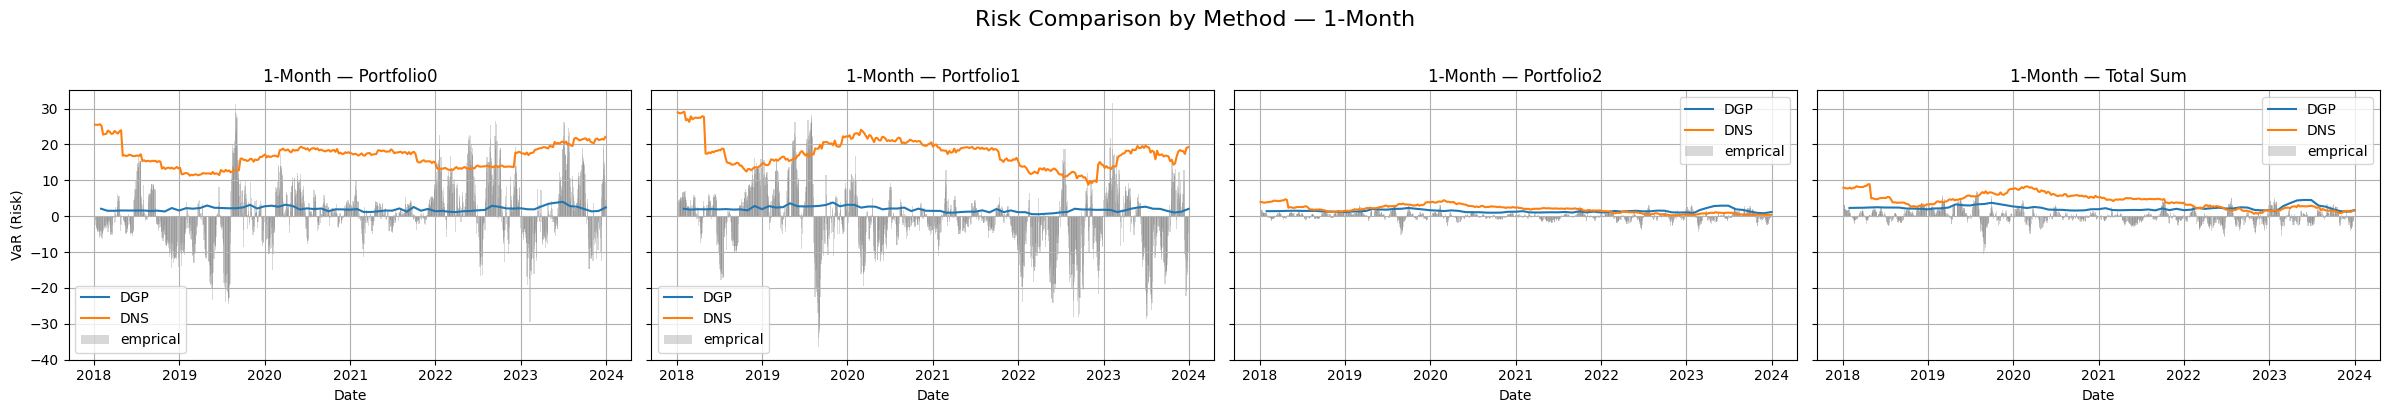

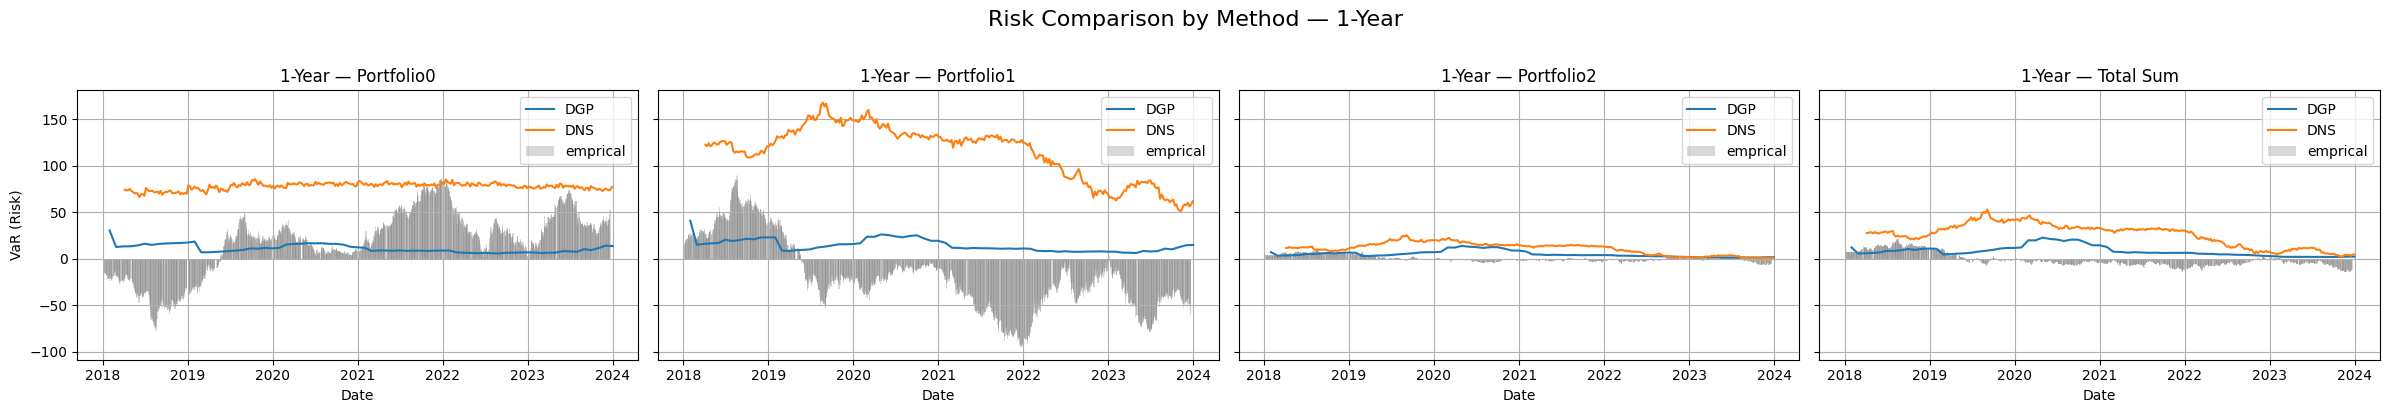

In [ ]:
start_date = pd.to_datetime("2018-01-01")
end_date   = pd.to_datetime("2023-12-31")

emp_risk_df = pd.read_csv("Empirical_risk_v3.1.csv", encoding="utf-8")
emp_risk_df["Base_Date"] = pd.to_datetime(emp_risk_df["Base_Date"])
emp_risk_df = emp_risk_df.rename(columns={
    "Base_Date":"Date",
    "Portfolio_0_risk": "Portfolio0",
    "Portfolio_1_risk": "Portfolio1",
    "Portfolio_2_risk": "Portfolio2",
    "Portfolio_3_risk": "PortfolioSum",
})
emp_risk_df["Label"] = "emprical"

# — DNS (1-Week & 1-Month)
from ast import literal_eval

def load_dns(path, horizon_label,model_label):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Test_Date"])
    df["Risk_Charges"] = df["Risk_Charges"].apply(literal_eval)
    risk = pd.DataFrame(df["Risk_Charges"].tolist(),
                        columns=["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"])
    df = pd.concat([df, risk], axis=1)
    df = df.drop(columns=["Test_Date","Risk_Charges"])
    df["Horizon"] = horizon_label
    df["Label"]   = model_label
    return df[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

dns_d = load_dns("DNS40_1-day_risk_backtest_v3.1.csv",  "1-Day", "DNS")
dns_w = load_dns("DNS40_1-week_risk_backtest_v3.1.csv",  "1-Week","DNS")
dns_m = load_dns("DNS40_1-month_risk_backtest_v3.1.csv","1-Month","DNS")
dns_y = load_dns("DNS40_1-year_risk_backtest_v3.1.csv","1-Year","DNS")

# — DGP (1-Month)
dgp_m = pd.read_csv("DGP_1-month_risk_v3.3.5.csv", encoding="utf-8")
dgp_m = dgp_m.rename(columns={
    "Test_Date":"Date",
    "VaR_Portfolio0":"Portfolio0",
    "VaR_Portfolio1":"Portfolio1",
    "VaR_Portfolio2":"Portfolio2",
    "VaR_Portfolio3":"PortfolioSum"
})
dgp_m["Date"]    = pd.to_datetime(dgp_m["Date"])
dgp_m["Horizon"] = "1-Month"
dgp_m["Label"]   = "DGP"
dgp_m = dgp_m[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

# — DGP (1-Year)
dgp_y = pd.read_csv("DGP_1-year_risk_v3.3.3.csv", encoding="utf-8")
dgp_y = dgp_y.rename(columns={
    "Test_Date":"Date",
    "VaR_Portfolio0":"Portfolio0",
    "VaR_Portfolio1":"Portfolio1",
    "VaR_Portfolio2":"Portfolio2",
    "VaR_Portfolio3":"PortfolioSum"
})
dgp_y["Date"]    = pd.to_datetime(dgp_y["Date"])
dgp_y["Horizon"] = "1-Year"
dgp_y["Label"]   = "DGP"
dgp_y = dgp_y[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

all_df = pd.concat([emp_risk_df, 
                    dns_d, dns_w, dns_m, 
                    dns_y, 
                    dgp_m, dgp_y,
                    ],
                   ignore_index=True)

mask = (all_df["Date"] >= start_date) & (all_df["Date"] <= end_date)
all_df = all_df.loc[mask].sort_values("Date")

horizon_order = ["1-Month", "1-Year"]

ports = ["Portfolio0", "Portfolio1", "Portfolio2","PortfolioSum"]

for horizon in horizon_order:
    df_h = all_df[all_df["Horizon"] == horizon]
    if df_h.empty:
        continue

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,4), sharey=True)
    for i, port in enumerate(ports):
        ax = axes[i]
        for label, grp in df_h.groupby("Label"):
            if label == "emprical":
                ax.bar(grp["Date"], grp[port],
                       width=5,
                       alpha=0.3,         
                       color="gray",      
                       label=label)
            else:
                ax.plot(grp["Date"], grp[port],
                        label=label)
        title = port if port!="PortfolioSum" else "Total Sum"
        ax.set_title(f"{horizon} — {title}")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("VaR (Risk)")
        ax.legend()
        ax.grid(True)

    fig.suptitle(f"Risk Comparison by Method — {horizon}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
